# Policy Gradient para Reinforcement Learning

In [1]:
!pip3 uninstall numpy -y
!pip3 install numpy==1.23.5
!pip3 install pygame

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.23.5-cp39-cp39-macosx_11_0_arm64.whl (13.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.24.0 requires pillow>=9.1, but you have pillow 9.0.0 which is incompatible.
faiss-cpu 1.9.0 requires numpy<3.0,>=1.25.0, but you have numpy 1.23.5 which is incompatible.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt

/Users/pedrom2/Library/Python/3.9/lib/python/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [3]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('threshold: ', env.spec.reward_threshold)

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)
threshold:  475.0


Este ambiente de gym es parte de https://www.gymlibrary.dev/environments/classic_control. El ambiente específico con el que trabajaremos en este notebook es https://www.gymlibrary.dev/environments/classic_control/cart_pole/

In [4]:
obs_size = env.observation_space.shape[0] 
n_actions = env.action_space.n  
HIDDEN_SIZE = 256

model = torch.nn.Sequential(
             torch.nn.Linear(obs_size, HIDDEN_SIZE),
             torch.nn.ReLU(),
             torch.nn.Linear(HIDDEN_SIZE, n_actions),
             torch.nn.Softmax(dim=0)
     )

print(model)

Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
  (3): Softmax(dim=0)
)


In [5]:
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Horizon = 500
MAX_TRAJECTORIES = 500
gamma = 0.99
score = [] 

for trajectory in range(MAX_TRAJECTORIES):
    curr_state = env.reset()
    done = False
    transitions = [] 
    
    for t in range(Horizon):
        if t == 0:
            act_prob = model(torch.from_numpy(curr_state[0]).float())
        else:
            act_prob = model(torch.from_numpy(curr_state).float())

        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy())

        if t == 0:
            prev_state = curr_state[0]
        else:
            prev_state = curr_state

        curr_state, _, done, info, _ = env.step(action)
        transitions.append((prev_state, action, t+1)) 

        if done: 
            break
        
    score.append(len(transitions))
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) 

    batch_Gvals =[]
    for i in range(len(transitions)):
        new_Gval=0
        power=0
        for j in range(i,len(transitions)):
             new_Gval=new_Gval+((gamma**power)*reward_batch[j]).numpy()
             power+=1
        batch_Gvals.append(new_Gval)
    expected_returns_batch=torch.FloatTensor(batch_Gvals)
    
    
    expected_returns_batch /= expected_returns_batch.max()

    state_batch = torch.Tensor([s for (s,a,r) in transitions]) 
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) 

    pred_batch = model(state_batch) 
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() 
    
    loss = - torch.sum(torch.log(prob_batch) * expected_returns_batch) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if trajectory % 50 == 0 and trajectory>0:
            print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, np.mean(score[-50:-1])))
     

/var/folders/_2/ssn9p4gn1zq96vptrk6db0940000gn/T/ipykernel_1792/1169610520.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  state_batch = torch.Tensor([s for (s,a,r) in transitions])


Trajectory 50	Average Score: 57.92
Trajectory 100	Average Score: 76.04
Trajectory 150	Average Score: 141.78
Trajectory 200	Average Score: 162.33
Trajectory 250	Average Score: 165.16
Trajectory 300	Average Score: 325.06
Trajectory 350	Average Score: 378.88
Trajectory 400	Average Score: 289.69
Trajectory 450	Average Score: 404.86


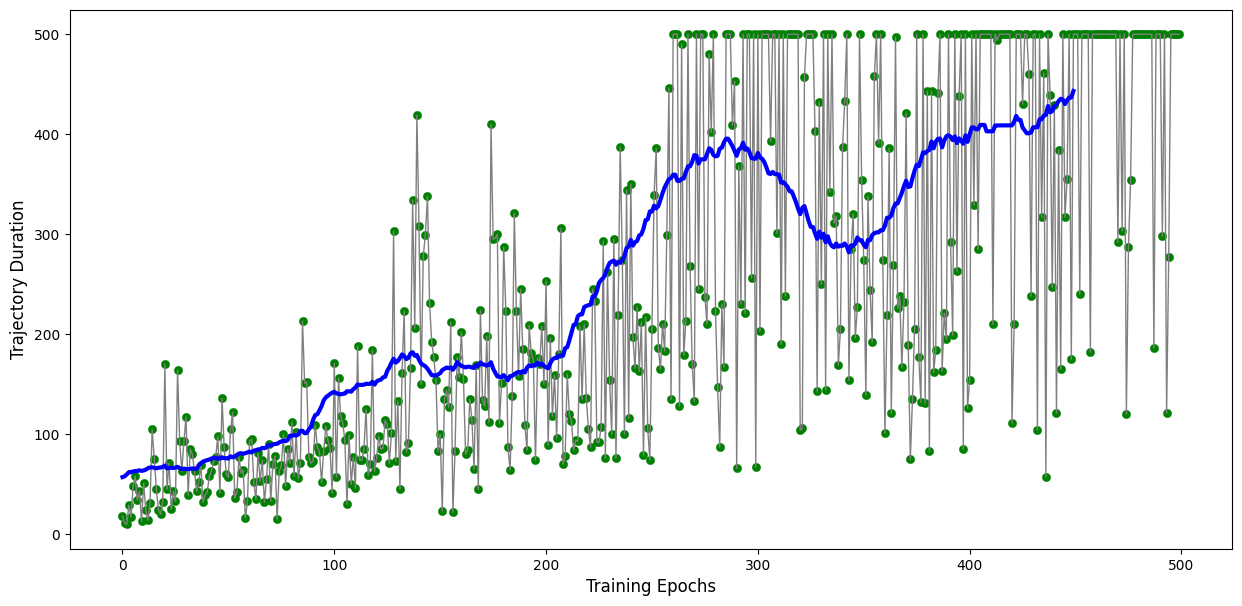

In [6]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y


score = np.array(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

In [ ]:
from tqdm import tqdm

n=500

env = gym.make("CartPole-v1", render_mode="human")
env.action_space.seed(82)

state = env.reset(seed=82)
rewards = []

for t in tqdm(range(n)):
    pred = model(torch.from_numpy(state[0]).float())
    action = np.random.choice(np.array([0,1]), p=pred.data.numpy())

    observation,reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    
    if terminated or truncated:
        observation, info = env.reset()
        print("Reward:", sum([r for r in rewards]))

env.close()

  3%|▎         | 17/500 [00:00<00:10, 46.21it/s]

Reward: 11.0


  7%|▋         | 37/500 [00:00<00:10, 45.45it/s]

Reward: 29.0


  9%|▉         | 47/500 [00:01<00:10, 44.70it/s]

Reward: 40.0


 11%|█▏        | 57/500 [00:01<00:09, 44.47it/s]

Reward: 52.0


 14%|█▍        | 72/500 [00:01<00:09, 45.05it/s]

Reward: 67.0


 17%|█▋        | 87/500 [00:01<00:09, 44.89it/s]

Reward: 78.0


 21%|██▏       | 107/500 [00:02<00:08, 45.38it/s]

Reward: 99.0


 23%|██▎       | 117/500 [00:02<00:08, 44.99it/s]

Reward: 108.0


 26%|██▋       | 132/500 [00:02<00:08, 44.94it/s]

Reward: 124.0


 30%|███       | 152/500 [00:03<00:07, 45.12it/s]

Reward: 147.0


 35%|███▌      | 177/500 [00:04<00:08, 38.56it/s]

Reward: 171.0


 40%|████      | 202/500 [00:04<00:06, 44.22it/s]

Reward: 194.0


 45%|████▌     | 227/500 [00:05<00:06, 45.32it/s]

Reward: 219.0


 48%|████▊     | 242/500 [00:05<00:05, 45.06it/s]

Reward: 236.0


 51%|█████▏    | 257/500 [00:05<00:05, 44.90it/s]

Reward: 251.0


 56%|█████▋    | 282/500 [00:06<00:04, 45.61it/s]

Reward: 273.0


 58%|█████▊    | 292/500 [00:06<00:04, 44.82it/s]

Reward: 285.0


 62%|██████▏   | 312/500 [00:07<00:04, 45.38it/s]

Reward: 303.0


 64%|██████▍   | 322/500 [00:07<00:03, 45.01it/s]

Reward: 313.0


 69%|██████▉   | 347/500 [00:07<00:03, 45.43it/s]

Reward: 341.0


 71%|███████▏  | 357/500 [00:08<00:03, 44.68it/s]

Reward: 351.0


 72%|███████▏  | 362/500 [00:08<00:03, 45.52it/s]

Reward: 364.0


 79%|███████▉  | 397/500 [00:09<00:02, 42.71it/s]

Reward: 390.0


 83%|████████▎ | 417/500 [00:09<00:01, 44.81it/s]

Reward: 412.0


 86%|████████▋ | 432/500 [00:09<00:01, 45.05it/s]

Reward: 423.0


 88%|████████▊ | 442/500 [00:10<00:01, 44.62it/s]

Reward: 434.0


 91%|█████████▏| 457/500 [00:10<00:00, 44.88it/s]

Reward: 449.0


 95%|█████████▌| 477/500 [00:10<00:00, 45.40it/s]

Reward: 470.0


100%|██████████| 500/500 [00:11<00:00, 43.84it/s]


: 

### Referencias

- https://lilianweng.github.io/posts/2018-02-19-rl-overview/#key-concepts
- https://lilianweng.github.io/posts/2018-04-08-policy-gradient/
- https://github.com/jorditorresBCN/Deep-Reinforcement-Learning-Explained/blob/master/DRL_19_REINFORCE_Algorithm.ipynb